## Instructions
- Please complete the following assignment using (preferrably) Python. I am using Python 3.7 v.
- If you feel like you have the time and skill set to complete all 2 exercises, feel free to do so.
- Please push the assignment onto a free, publicly available repository for review (e.g. GitHub or Gitlab).
- You are free to use any open source library or package to complete the exercises.

## Assumptions

- Since there is no one 'price' column in the formulation of the problem + dataset, I am defining the 'price' target variable as being the mean of amountMin and amountMax prices, both converted to USD. ~0.03% of rows in the dataset have amountMin != amountMax, therefore it was a reasonable assumption to make.<br> i.e. we are assuming that the bias introduced by the currency conversion of the price is negligeable. Furthermore, I left the currency column in the model as an categorical variable to see if it has much feature importance on the target variable, price.

- Assuming that each row represents a product-price_range per set of listing URLs: more explicitly each row represents a range of prices, captured by prices.amountMin and prices.amountMax, which were each seen on the prices.sourceURLs of that row (there may be multiple sources on which those prices were seen).

# Introduction

Given the time constraint of this assignment, the focus of this exercise was on using a simple but reliable model to generate a reasonably good performance (using MSE, RMSE, R2 as my evaluation metric(s)) and comparing it to a more complex supervised learning model. The accuracy of the model saw the greatest improvement by developing the "Data Cleaning", "Feature Engineering" and "Model Implementation" sections.

This notebook outlines the following components of my analysis:

    1) Read Data
    2) Data Cleaning
    3) Feature Engineering
    4) EDA
    5) Benchmarking
    6) Model Implementation (LightGBM)
    7) Future Improvements

In [1]:
# import libraries required for analysis

import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
import datetime as dt
from dateutil.relativedelta import relativedelta

import tldextract as tldextract
# from currency_converter import CurrencyConverter

import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

import lightgbm as lgb

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# initialize necessary directories and params
os.chdir('/Users/estevanfalcone/Nulogy/Nulogy_DataScience_Pricing_Assignment/')

# 1. Read Data
- Investigate problematic rows at import (hypothesizing that it's JSON column foratting interfering with column splitting). 

In [3]:
# limits # of rows to read (None to read entire dataset)
nRowsRead = None

data = pd.read_csv('product_data_schema.csv', nrows = nRowsRead, low_memory = False, 
                   error_bad_lines = False)
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (19387, 48)


,id,asins,brand,categories,colors,count,dateAdded,dateUpdated,descriptions,dimension,...,prices.warranty,quantities,reviews,sizes,skus,sourceURLs,upc,vin,websiteIDs,weight
0,AVpfHrJ6ilAPnD_xVXOI,NaN,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,NaN,2016-11-07T00:45:12Z,2016-11-07T00:45:12Z,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,...,NaN,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Josmo-8190-Plain-In...,699302044036,NaN,NaN,NaN
1,AVpfHrJ6ilAPnD_xVXOI,NaN,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,NaN,2016-11-07T00:45:12Z,2016-11-07T00:45:12Z,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,...,NaN,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Josmo-8190-Plain-In...,699302044036,NaN,NaN,NaN
2,AVpfHsWP1cnluZ0-eVZ7,NaN,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,NaN,2016-06-14T04:29:57Z,2016-07-09T20:26:48Z,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,...,NaN,NaN,NaN,NaN,NaN,http://www.walmart.com/ip/Studs-Shoe-Large-Pr-...,NaN,NaN,NaN,NaN
3,AVpfHsWP1cnluZ0-eVZ7,NaN,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,NaN,2016-06-14T04:29:57Z,2016-07-09T20:26:48Z,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,...,NaN,NaN,NaN,NaN,NaN,http://www.walmart.com/ip/Studs-Shoe-Large-Pr-...,NaN,NaN,NaN,NaN
4,AVpfHsWP1cnluZ0-eVZ7,NaN,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,NaN,2016-06-14T04:29:57Z,2016-07-09T20:26:48Z,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,...,NaN,NaN,NaN,NaN,NaN,http://www.walmart.com/ip/Studs-Shoe-Large-Pr-...,NaN,NaN,NaN,NaN


# 2. Data Cleaning

### Data Type and Missing Data Cleaning

In [4]:
data.dtypes

id                      object
asins                   object
brand                   object
categories              object
colors                  object
count                  float64
dateAdded               object
dateUpdated             object
descriptions            object
dimension               object
ean                     object
features                object
flavors                float64
imageURLs               object
isbn                   float64
keys                    object
manufacturer            object
manufacturerNumber      object
merchants               object
name                    object
prices.amountMin       float64
prices.amountMax       float64
prices.availability     object
prices.color            object
prices.condition        object
prices.count            object
prices.currency         object
prices.dateAdded        object
prices.dateSeen         object
prices.flavor           object
prices.isSale           object
prices.merchant         object
prices.o

First, start by verifying if there are any duplicated rows in the data and remove them:

In [5]:
f'duplicate rows: {data.duplicated().sum()}'
data.drop_duplicates(inplace=True)
print(data.shape)

(19383, 48)


Remove non-ASCII char entries from dataset:

In [6]:
objects_columns = data.select_dtypes(object)
objects_columns = objects_columns.drop(['prices.availability','prices.count',
                                        'prices.flavor','prices.isSale'],axis=1)
data[objects_columns.columns] = objects_columns.apply(lambda x: x.str.encode('ascii', 'ignore')
                                                      .str.decode('ascii'))

Find columns with no data (i.e. number of missing values == number of rows of dataset) and remove them:

In [7]:
# find columns with entirely missing data
null_sums_per_col = data.isna().sum()
null_columns = list(null_sums_per_col[null_sums_per_col == data.shape[0]].index)
print(null_columns)

['count', 'flavors', 'isbn', 'prices.source', 'prices.warranty', 'quantities', 'vin', 'websiteIDs']


In [8]:
# remove these null columns from the dataset
data1 = data.drop(null_columns, 'columns')
print(data1.shape)

(19383, 40)


Determine how much data (quantity and proportion) is missing per column:

In [9]:
# print quantity/ratio of missing values
missing_data_metrics = {'missing_quantity': data1.isnull().sum(),
    'missing_ratio': data1.isnull().sum() * 100 / len(data1)}

missing_data_metrics_df = pd.DataFrame(data = missing_data_metrics)
print(missing_data_metrics_df.sort_values(by = ['missing_ratio'], ascending = False))

                     missing_quantity  missing_ratio
prices.count                    19371      99.938090
prices.flavor                   19356      99.860703
prices.availability             19314      99.644018
prices.size                     18730      96.631068
prices.color                    18610      96.011969
weight                          18526      95.578600
prices.returnPolicy             18358      94.711861
reviews                         17709      91.363566
asins                           16815      86.751277
dimension                       16369      84.450291
prices.shipping                 13682      70.587628
sizes                           13391      69.086313
prices.offer                    13329      68.766445
manufacturer                    12684      65.438787
skus                            10637      54.877986
descriptions                     9493      48.975907
ean                              9381      48.398081
upc                              8605      44.

In [10]:
f'There are {len(missing_data_metrics_df[missing_data_metrics_df.missing_ratio >= 45])} of {len(missing_data_metrics_df)} features missing 45% or more of their data.'

'There are 17 of 40 features missing 45% or more of their data.'

Many of these columns (including some of the ones with less missing data) will likely end up being dropped from the analysis in the interest of time. *See 'Future Improvements' for further analysis that could be done to some of said columns given additional time.*

In [11]:
data1['colors'].value_counts()
data1['colors'].isna().sum()

8366

### Gender
Filter out any Female Gender products erroneously in the data (given we want only Men's Shoe Prices).
- By assumption, we will keep the Unisex products.

In [12]:
data1['gender'] = data1.features.str.split(pat='"key":"Gender","value":\["',expand=True)[1].str.split(pat='"\]}',expand=True)[0]
data1['gender'] = data1['gender'].str.replace("'","")
data1['gender'] = data1['gender'].str.replace('"','')
data1['gender'] = data1['gender'].str.strip()
data1['gender'].value_counts()

Men                     7520
Unisex                  1144
Boys                     144
Male                     142
Women                    105
Mens                     102
Girls                     71
Women , Men               15
Male,Men                  11
Men,Unisex                11
Unisex Adults             10
Men,Women                  9
Men,Mens                   8
Men,Boys                   7
Adult Unisex               7
Unisex, Mens, Womens       6
Women,Men                  6
Men / Women                5
Female                     4
Mens, Womens, Unisex       4
Boys,Men                   3
Men,Adult Unisex           3
Male,Mens                  3
Men,mens                   2
Unisex Adult               2
Womens                     2
Women,Unisex               1
Mens Womens                1
Does not apply             1
Name: gender, dtype: int64

In [13]:
# remove rows that are not Mens, Boys or Unisex
data1 = data1.loc[(data1.gender!='Womens') & (data1.gender!='Girls') & (data1.gender!='Women') & (data1.gender!='Female')]
print(data1.shape)

(19201, 41)


In [14]:
# map to fewer encodings based on description
gender_map = {
    'Male':'Men',
    'Mens':'Men',
    'Women , Men':'Unisex',
    'Men,Unisex':'Unisex',
    'Male,Men':'Men',
    'Unisex Adults':'Unisex',
    'Men,Women':'Unisex',
    'Men,Mens':'Men',
    'Men,Boys':'Men',
    'Adult Unisex':'Unisex',
    'Unisex, Mens, Womens':'Unisex',
    'Women,Men':'Unisex',
    'Men / Women':'Unisex',
    'Mens, Womens, Unisex':'Unisex',
    'Men,Adult Unisex':'Unisex',
    'Male,Mens':'Men',
    'Boys,Men':'Men',
    'Men,mens':'Men',
    'Unisex Adult':'Unisex',
    'Mens Womens':'Unisex',
    'Women,Unisex':'Unisex'
}
data1['gender'] = data1['gender'].replace(gender_map)

# upon inspection, remove since *not* men's shoes
index = data1['gender'] == 'Does not apply'
data1 = data1[-index]

### Categories
Sanity-check that the data contains 'Shoes' in Categories (and not other Category products).

In [15]:
data1['categories'] = data1['categories'].str.lower()
index = data1['categories'].str.contains('shoe')
index.value_counts()

True     19173
False       27
Name: categories, dtype: int64

In [16]:
data1 = data1[index == True]
print(data1.shape)

(19173, 41)


### isSale Flag
Upon close inspection, this flag does accurately show whether a particular line price has been discounted or not. We will simply encode the binary feature. Since the percentage of missing values for prices.isSale col is small, we will impute the missing values with the categorical mode (notably, isSale = False).

In [17]:
# fill missing values with mode (False) and convert to int
data1['prices.isSale'] = data1['prices.isSale'].fillna(False)
data1['isSale'] = data1['prices.isSale'].astype(int)
data1['isSale'].value_counts()

0    13564
1     5609
Name: isSale, dtype: int64

In [18]:
# drop the redundant isSale column
data1 = data1.drop('prices.isSale','columns')
data1.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'descriptions', 'dimension', 'ean', 'features',
       'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'merchants',
       'name', 'prices.amountMin', 'prices.amountMax', 'prices.availability',
       'prices.color', 'prices.condition', 'prices.count', 'prices.currency',
       'prices.dateAdded', 'prices.dateSeen', 'prices.flavor',
       'prices.merchant', 'prices.offer', 'prices.returnPolicy',
       'prices.shipping', 'prices.size', 'prices.sourceURLs', 'reviews',
       'sizes', 'skus', 'sourceURLs', 'upc', 'weight', 'gender', 'isSale'],
      dtype='object')

### Date Features
- Convert any date-time columns to appropriate date-time type.
- Extract Month and Year from Date variables of interest; in particular, prices.dateSeen. Remove rows with missing dates - considered using an average date between min and max, but formatting errors exist in other rows for these data points (i.e. safer to remove them).

In [19]:
# remove NA prices.dateSeen rows and rename 'dateSeen' col with it
index = data1['prices.dateSeen'].isna()
data1 = data1[-index]
data1 = data1.drop(['dateAdded','dateUpdated','prices.dateAdded'],'columns')
data1['dateSeen'] = data1['prices.dateSeen']
data1 = data1.drop(['prices.dateSeen'],'columns')

data1.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'descriptions',
       'dimension', 'ean', 'features', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'name', 'prices.amountMin',
       'prices.amountMax', 'prices.availability', 'prices.color',
       'prices.condition', 'prices.count', 'prices.currency', 'prices.flavor',
       'prices.merchant', 'prices.offer', 'prices.returnPolicy',
       'prices.shipping', 'prices.size', 'prices.sourceURLs', 'reviews',
       'sizes', 'skus', 'sourceURLs', 'upc', 'weight', 'gender', 'isSale',
       'dateSeen'],
      dtype='object')

In [20]:
# convert dateSeen to date-time format
data1 = data1.assign(
    dateSeen = pd.to_datetime(pd.to_datetime(data1.dateSeen).dt.date)
)
print(data1.shape)

(19148, 38)


### Currency (cleaning)
Filter out erroneous currencies (it's imperative to have correct currencies for prices - desired target variable - to make sense).

In [21]:
data1['prices.currency'].value_counts()

USD    18379
AUD      337
CAD      303
EUR      107
GBP       22
Name: prices.currency, dtype: int64

In [22]:
curr = list(['USD','AUD','CAD','GBP','EUR'])
data1 = data1[data1['prices.currency'].isin(curr)]
print(data1.shape)
data1['prices.currency'].value_counts()

(19148, 38)


USD    18379
AUD      337
CAD      303
EUR      107
GBP       22
Name: prices.currency, dtype: int64

### Brands
- This could potentially be made more intelligent using techniques like fuzzy string matching, but in the interest of time, I made a map for the cases I could detect visually.

In [23]:
data1['brand'] = data1['brand'].str.strip().str.lower()
data1['brand'].value_counts().sort_values(ascending=False)

nike                           1763
ralph lauren                    700
puma                            651
vans                            386
new balance                     364
reebok                          271
adidas                          255
jordan                          193
superior glove works            187
fuse lenses                     174
fossa apparel                   174
skechers                        164
converse                        144
dickies                         144
unique bargains                 142
unbranded                       140
berne apparel                   126
asics                           122
crocs                           120
kinco                           110
toms                            108
national safety apparel inc     107
under armour                    105
gameday boots                   103
carhartt                         99
stacy adams                      98
scully                           96
georgia boot                

In [24]:
# brand names to change (note: must be certain of brand mapping fixes)
brand_map = {
    '3drose llc':'3drose',
    '3n2':'3n2 sports',
    '3m (formerly aearo)':'3m',
    'academie gear':'academie',
    'adidas outdoors':'adidas',
    'adidas performance':'adidas',
    'adidas crazy1 kobe bb shoes':'adidas',
    'adidas crazy 8 ny knicks':'adidas',
    'aearo':'3m',
    'alexander mcqueen by puma':'alexander mcqueen',
    'alexanders costumes':'alexanders',
    'american eagle outfitters':'american eagle',
    'and 1':'and1',
    'augusta sportswear':'augusta',
    'baffin inc':'baffin',
    'berne apparel':'berne',
    'blackhawk!':'blackhawk',
    'boss hugo boss':'hugo boss',
    'california costume':'california costumes',
    'calvin klein jeans':'calvin klein',
    'champ':'champion',
    'cufflink aficionado':'cufflinks',
    'cufflink inc':'cufflinks',
    'dan post boots':'dan post',
    'dc shoes':'dc',
    'diamondback fitness':'diamondback',
    'diesel black gold':'diesel',
    'dije california':'dije',
    'dolce e gabbana':'dolce gabbana',
    'dolce & gabbana':'dolce gabbana',
    'dr. martens air wair':'dr. martens',
    'dr. martens work':'dr. martens',
    'ellie shoes':'ellie',
    'fitflop.':'fitflop',
    'forever collectibles':'forever collectible',
    'fox outdoor products':'fox outdoor',
    'franco american novelties':'franco',
    'ganesha handicrafts':'ganesha handicraft',
    'ganeshahandicraft':'ganesha handicraft',
    "Ganesha Handicraft \",\"Clothing, Shoes & Accessories,Men's Accessories,Backpacks, Bags & Briefcases":'ganesha handicraft',
    'gearonic tm':'gearonic',
    'generic':'unbranded',
    'generic / unbranded':'unbranded',
    'generic surplus':'surplus',
    'genuine dickies':'dickies',
    'georgia boot':'georgia',
    'gifts infinity':'gifts',
    'gola classics':'gola',
    'handmadecart':'handmadecraft',
    'hao_bo':'hao-bo',
    'holloway sportswear':'holloway',
    "hot chilly's":'hot chillys',
    'hugo by hugo boss':'hugo boss',
    'incharacter costumes':'incharacter',
    'j`s awake':"j's awake",
    'jewelrywe':'jewelryweb',
    "joe's":'joes',
    'justin boots':'justin',
    'justin original work boots':'justin',
    'justin original workboots':'justin',
    'k- swiss':'k-swiss',
    'kenneth cole new yor':'kenneth cole',
    'kenneth cole new york':'kenneth cole',
    'kenneth cole ny':'kenneth cole',
    'key apparel':'key',
    'lacrosse footwear':'lacrosse',
    'lauren ralph lauren':'ralph lauren',
    'levi strauss & co.':'levis',
    'levi strauss':'levis',
    "levi's":'levis',
    "levy's":'levis',
    'magid glove and safety (industrial)':'magid glove and safety',
    'majestic glove':'majestic',
    'mancini leather goods':'mancini leather',
    'marc new york by andrew marc':'marc new york',
    'marc ny':'marc new york',
    'maui jim 142-10':'maui jim',
    'mg:dakota':'mg',
    'mg:gn':'mg',
    'michael michael kors':'michael kors',
    'micro flex':'microflex',
    'milkoloti':'miko lotti',
    'milwaukee electric tool':'milwaukee',
    'minnetonka men':'minnetonka',
    'minnetonka moccasin company, inc.':"minnetonka",
    'minx nyamp44 inc':'minx ny',
    'mln':'mlb',
    'muck boot team j':'muck boot',
    'muck boots':'muck boot',
    'muckboot':'muck boot',
    'national safety apparel inc':'national safety apparel',
    'new balance numeric':'new balance',
    'newbalance':'new balance',
    'nike - kobe':'nike',
    'nike air jordan i':'nike air jordan',
    'nike jordan future low':'nike air jordan',
    'nike lunarglide 7':'nike',
    'nike sb':'nike',
    'norcross safety':'norcross',
    'norcross safety prod':'norcross',
    'norcross safety products':'norcross',
    'north safety / honeywell':'honeywell',
    "o'neill":"o'neal",
    'onguard industries':'onguard',
    'original s.w.a.t.':'original swat',
    'otto:dakota':'otto',
    'otto:gn':'otto',
    'palmbeach jewelry':'palm beach jewelry',
    'pearl izumi - run':'pearl izumi',
    'perry ellis portfolio':'perry ellis',
    'pf-flyers':'pf flyers',
    'polaroid sunglasses':'polaroid',
    'polo ralph lauren golf':'polo ralph lauren',
    'polo sport ralph lauren':'polo ralph lauren',
    'prada sport':'prada',
    'principle plastics inc':'principle plastics',
    'propet':'proper',
    'ralph lauren black label':'ralph lauren',
    'ralph lauren polo':'ralph lauren',
    'ralph lauren purple label':'ralph lauren',
    'ralph lauren rlx':'ralph lauren',
    'ralph lauren rrl':'ralph lauren',
    'ralph lauren yacht':'ralph lauren',
    'ranger by honeywell':'ranger',
    'ray-ban':'rayban',
    'ray ban':'rayban',
    'reaction kenneth cole':'kenneth cole reaction',
    'red wing heritage':'red wing',
    'red wing shoes':'red wing',
    'reebok nfl equipment':'reebok',
    'reef footwear':'reef',
    'ridge footwear':'ridge',
    'ridge outdoors':'ridge',
    'river city clocks':'river city',
    'river city garments':'river city',
    'rockport works':'rockport',
    'rockport xcs':'rockport',
    'salomon, salomon':'salomon',
    'serengeti eyewear':'serengeti',
    'signature by levi strauss & co.':'levis',
    'signature by levi strauss &amp; co':'levis',
    'slipperooz by deer stags':'slipperooz',
    "smiffy's":'smiffys',
    'solo, solo':'solo',
    'sondooongmart':'sondoongmart',
    'sperry top sider':'sperry',
    'sperry top-sider':'sperry',
    'team beans, l.l.c':'team beans',
    'the original muck boot co.':'the original muck boot company',
    'the original swat footwear co':'the original swat footwear',
    'timberland boot company':'timberland',
    'tingley rubber corp.':'tingley rubber',
    'toms footwear':'toms',
    'tony lama boot co.':'tony lama',
    'totes isotoner':'totes',
    'u.s polo assn.':'u.s. polo assn.',
    'u.s. polo assn. classic':'u.s. polo assn.',
    'u.s. polo association':'u.s. polo assn.',
    'ugg australia':'ugg',
    'ugg mens':'ugg',
    'unbrand':'unbranded',
    'unbranded/generic':'unbranded',
    'under armour':'under armor',
    'under armour outerwear':'under armor',
    'us polo':'u.s. polo assn.',
    'us polo assn':'u.s. polo assn.',
    'vans av78':'vans',
    'vans footwear':'vans',
    'vasque footwear':'vasque',
    'venum':'venom',
    'vionic by orthaheel':'vionic',
    'vionic with orthaheel technology':'vionic',
    'vogue code':'vogue',
    'vonzipper':'von zipper',
    'walleva (not an oakley product)':'walleva',
    'westchester':'west chester',
    'wings & horns':'wings + horns',
    "wood n' stream":'wood n stream',
    'wrangler riggs':'wrangler',
    'zoot sports':'zoot'
}

data1['brand_clean'] = data1.brand.replace(brand_map)

data1['brand_clean'].value_counts()

nike                        1767
ralph lauren                 712
puma                         651
vans                         394
new balance                  371
reebok                       273
adidas                       259
jordan                       193
superior glove works         187
unbranded                    184
fuse lenses                  174
fossa apparel                174
skechers                     164
dickies                      154
converse                     144
unique bargains              142
justin                       141
berne                        137
asics                        122
crocs                        120
national safety apparel      119
kinco                        110
toms                         110
under armor                  107
onguard                      103
gameday boots                103
kenneth cole                 100
carhartt                      99
georgia                       98
stacy adams                   98
          

In [25]:
index = data1['brand'].isna()
data1 = data1[-index]
data1.shape

(18890, 39)

# 3. Feature Engineering

For feature engineering, I'll attempt to create additional features from the existing data that I believe will assist in my model's performance. Some additional cleaning and/or imputing may be required along the way.

### freeShipping Flag
- 1 for offers free shipping and/or returns, 0 for doesn't; 2 for 'missing' flag

_Note: I've lumped free Shipping and free Returns together, could be improved on in 'Future Improvements'._

In [26]:
# create categorical variable for free shipping or not; include a missing flag
data1['prices.shipping'] = data1['prices.shipping'].str.strip().str.lower()

data1['prices.shipping'] = data1['prices.shipping'].fillna('missing')

conditions = [
    data1['prices.shipping'] == 'missing',
    data1['prices.shipping'].str.contains('free')]
choices = [2,1]
data1['freeShipping'] = np.select(conditions, choices, default=0)

data1['freeShipping'].value_counts()

2    13468
1     3799
0     1623
Name: freeShipping, dtype: int64

### isBid Flag
- 1 for whether the purchase was a winning bid, 0 for wasn't; 2 for 'missing' flag

In [27]:
# create categorical variable for winning bid or not; include a missing flag
data1['prices.offer'] = data1['prices.offer'].str.strip().str.lower()

data1['prices.offer'] = data1['prices.offer'].fillna('missing')

conditions = [
    data1['prices.offer'] == 'missing',
    data1['prices.offer'].str.contains('winning bid')]
choices = [2,1]
data1['isBid'] = np.select(conditions, choices, default=0)

data1['isBid'].value_counts()

2    13026
0     4618
1     1246
Name: isBid, dtype: int64

### isNew Flag
- 1 for whether the purchase was new, 0 for wasn't; 2 for 'missing' flag

In [28]:
# create categorical variable for isNew or not; include a missing flag
data1['prices.condition'] = data1['prices.condition'].str.strip().str.lower()

index = data1['prices.condition'] == 'amazon.com'
data1 = data1[-index]

data1['isNew'] = data1['prices.condition'].fillna('missing')

condition_map = {
    'brand new':'new',
    'new with box':'new',
    'new with tags':'new',
    'new without box':'new',
    'new without tags':'new',
    'pre-owned':'used'
}

data1['isNew'] = data1['isNew'].replace(condition_map)

data1['isNew'].value_counts()

new                 12013
missing              6664
used                  164
new with defects       49
Name: isNew, dtype: int64

### withBox Flag
- 1 for whether the purchase had a box, 0 for didn't; 2 for 'missing' flag

In [29]:
data1['withBox'] = data1['prices.condition'].fillna('missing')

conditions = [
    data1['withBox'] == 'missing',
    data1['withBox'].str.contains('with box'),
    data1['withBox'].str.contains('without box')
]
choices = ['missing','with_box','without_box']
data1['withBox'] = np.select(conditions, choices, default='missing')

data1['withBox'].value_counts()

missing        17468
with_box        1063
without_box      359
Name: withBox, dtype: int64

### withTags Flag
- 1 for whether the purchase had tags, 0 for didn't; 2 for 'missing' flag

In [30]:
data1['withTags'] = data1['prices.condition'].fillna('missing')

conditions = [
    data1['withTags'] == 'missing',
    data1['withTags'].str.contains('with tags'),
    data1['withTags'].str.contains('without tags')
]
choices = ['missing','with_tags','without_tags']
data1['withTags'] = np.select(conditions, choices, default='missing')

data1['withTags'].value_counts()

missing         17064
with_tags        1683
without_tags      143
Name: withTags, dtype: int64

### Datetime Features
Create the following new features from the 'dateSeen' column (i.e. when a particular price was seen):
- duration_since_dateSeen_month: _Duration in months since a particular price (row) was seen._
- dateSeen_month: _Month when a particular price (row) was seen._
- dateSeen_year: _Year when a particular price (row) was seen._

In [31]:
# create new Date Features
data1 = data1.assign(
    duration_since_dateSeen_month = ((dt.datetime.now() - data1.dateSeen)/np.timedelta64(1, 'M')),
    dateSeen_month = data1.dateSeen.dt.month,
    dateSeen_year = data1.dateSeen.dt.year
)
data1.head()

,id,asins,brand,categories,colors,descriptions,dimension,ean,features,imageURLs,...,dateSeen,brand_clean,freeShipping,isBid,isNew,withBox,withTags,duration_since_dateSeen_month,dateSeen_month,dateSeen_year
0,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoes,men's shoes,all men's shoes",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,2016-11-05,josmo,2,0,missing,missing,missing,33.534298,11,2016
1,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoes,men's shoes,all men's shoes",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,2016-11-05,josmo,2,0,new,missing,missing,33.534298,11,2016
2,AVpfHsWP1cnluZ0-eVZ7,NaN,servus by honeywell,"all men's shoes,shoes,men's shoes,clothing",NaN,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,NaN,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Colo...",http://i5.walmartimages.com/dfw/dce07b8c-5844/...,...,2016-03-08,servus by honeywell,2,2,new,missing,missing,41.485180,3,2016
3,AVpfHsWP1cnluZ0-eVZ7,NaN,servus by honeywell,"all men's shoes,shoes,men's shoes,clothing",NaN,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,NaN,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Colo...",http://i5.walmartimages.com/dfw/dce07b8c-5844/...,...,2015-11-30,servus by honeywell,2,2,new,missing,missing,44.737814,11,2015
4,AVpfHsWP1cnluZ0-eVZ7,NaN,servus by honeywell,"all men's shoes,shoes,men's shoes,clothing",NaN,"[{""dateSeen"":[""2016-07-09T20:26:48Z""],""sourceU...",NaN,NaN,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Colo...",http://i5.walmartimages.com/dfw/dce07b8c-5844/...,...,2016-04-29,servus by honeywell,2,2,new,missing,missing,39.776726,4,2016


### URL Features

Using basic string manipulations, I want to see whether I can extract some meaningful categorical labels for websites on which the stored prices were seen.
- A discount store like Walmart or a bidding site like eBay (often used goods) might price products lower than a luxury fashion retailer like SSENSE.
- I'm also curious to see just how many different sources (base URLs) are being scraped for prices.

In [32]:
data1['sourceURLs'] = data1['sourceURLs'].fillna('missing')
data1['prices.sourceURLs'] = data1['prices.sourceURLs'].fillna('missing')

conditions = [
    data1['sourceURLs'] != 'missing',
    data1['prices.sourceURLs'] != 'missing']
choices = [data1['sourceURLs'],data1['prices.sourceURLs']]
data1['URL_clean'] = np.select(conditions, choices, default='missing')

data1['URL_domain_clean'] = data1['URL_clean'].apply(lambda url: tldextract.extract(url).domain)
data1['URL_domain_clean'].value_counts()

walmart                                                         8648
ebay                                                            3578
sears                                                           3471
amazon                                                          1916
ralphlauren                                                      674
sportsauthority                                                  169
nordstrom                                                        110
newegg                                                            68
macys                                                             58
shoes                                                             48
puma                                                              40
gandermountain                                                    33
kmart                                                             20
overstock                                                         17
sunglassesshop                    

In [33]:
# upon close inspection, remove sunglasses anomalies
index = data1['URL_domain_clean'] == 'sunglassesshop'
data1 = data1[-index]

In [34]:
index = data1['URL_domain_clean'] == 'missing'
data1[index]

,id,asins,brand,categories,colors,descriptions,dimension,ean,features,imageURLs,...,freeShipping,isBid,isNew,withBox,withTags,duration_since_dateSeen_month,dateSeen_month,dateSeen_year,URL_clean,URL_domain_clean
1390,AVpfCauiilAPnD_xTlFQ,"B009E2JPBK,B009E2JK8S",burberry,"accessories,sunglasses,men,shoes,clothing, sho...",NaN,NaN,NaN,NaN,NaN,http://ecx.images-amazon.com/images/I/31PBPB8N...,...,0,2,missing,missing,missing,41.419471,3,2016,missing,missing
1392,AVpfCauiilAPnD_xTlFQ,"B009E2JPBK,B009E2JK8S",burberry,"accessories,sunglasses,men,shoes,clothing, sho...",NaN,NaN,NaN,NaN,NaN,http://ecx.images-amazon.com/images/I/31PBPB8N...,...,0,2,missing,missing,missing,41.386616,3,2016,missing,missing


Since both missing URLs are Burberry brand products, let's see what domain sells the most Burberry brand (i.e. mode).

In [35]:
index = data1['brand'] == 'burberry'
data1[index]['URL_domain_clean'].value_counts()

amazon     32
missing     2
ebay        1
Name: URL_domain_clean, dtype: int64

In [36]:
# replace the missing URL domain with the mode for brand 'Burberry'
URL_map = {
    'missing':'amazon'
}
data1['URL_domain_clean'] = data1['URL_domain_clean'].replace(URL_map)

Out of curiosity, let's see what domains have 'winning bids' for prices.

In [37]:
# check what websites you can bid on
cond_one = data1['isBid'] == 1
data1[cond_one]['URL_domain_clean'].value_counts()

ebay       1215
walmart      27
sears         2
amazon        2
Name: URL_domain_clean, dtype: int64

As expected, most of the 'winning bid' prices were on eBay. Unsure of whether the rest are just anomalous, but will leave them in for the time being (another 'Future Improvement' to investigate).

### Currency (conversion)

For this analysis, we will convert all prices to USD - i.e. use USD price as target variable.
- Alternative would be to predict prices in each currency, at which point the target variable would be imbalanced in the dataset since there is an overwhelming majority of USD price data points in the dataset. (Added to 'Future Improvements' section.)

In [38]:
from currency_converter import CurrencyConverter
EUR = CurrencyConverter().convert(1, currency= 'EUR', new_currency= 'USD');
CAD = CurrencyConverter().convert(1, currency= 'CAD', new_currency= 'USD');
AUD = CurrencyConverter().convert(1, currency= 'AUD', new_currency= 'USD');
GBP = CurrencyConverter().convert(1, currency= 'GBP', new_currency= 'USD');

# just to have a conversion column
data1['conversion'] = pd.DataFrame(np.ones(data1.shape[1]))
for index, row in data1.iterrows(): 
    if (data1['prices.currency'][index]=='EUR'): data1['conversion']= EUR
    if (data1['prices.currency'][index]=='CAD'): data1['conversion']= CAD
    if (data1['prices.currency'][index]=='AUD'): data1['conversion']= AUD
    if (data1['prices.currency'][index]=='GBP'): data1['conversion']= GBP

In [39]:
f"{EUR},{CAD},{AUD},{GBP}"

'1.1209,0.7434009815625414,0.7039944730561486,1.2951643653590617'

In [40]:
data1['prices.amountMin_converted'] = data1['prices.amountMin'].copy()
data1['prices.amountMax_converted'] = data1['prices.amountMax'].copy()


data1.loc[data1['prices.currency']=='EUR', 'prices.amountMin_converted'] = data1['prices.amountMin']*EUR
data1.loc[data1['prices.currency']=='EUR', 'prices.amountMax_converted'] = data1['prices.amountMax']*EUR
data1.loc[data1['prices.currency']=='CAD', 'prices.amountMin_converted'] = data1['prices.amountMin']*CAD
data1.loc[data1['prices.currency']=='CAD', 'prices.amountMax_converted'] = data1['prices.amountMax']*CAD
data1.loc[data1['prices.currency']=='AUD', 'prices.amountMin_converted'] = data1['prices.amountMin']*AUD
data1.loc[data1['prices.currency']=='AUD', 'prices.amountMax_converted'] = data1['prices.amountMax']*AUD
data1.loc[data1['prices.currency']=='GBP', 'prices.amountMin_converted'] = data1['prices.amountMin']*GBP
data1.loc[data1['prices.currency']=='GBP', 'prices.amountMax_converted'] = data1['prices.amountMax']*GBP

# 4. Exploratory Data Analysis

Note that the EDA for this Notebook was performed before (as well as in tandem with) the previous Feature Engineering step. I found myself cycling between steps 2, 3 and 4, which is fairly common place.

### Temporal Exploration

These are the following counts by year:
   year  count
3  2014     27
2  2015   2505
0  2016  13049
1  2017   3293


<BarContainer object of 4 artists>

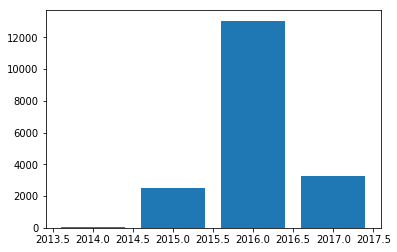

In [41]:
year_counts = (data1['dateSeen_year'].value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'year', 'dateSeen_year': 'count'})
                )
print('These are the following counts by year:')
print(year_counts)
plt.bar(year_counts['year'], year_counts['count'])

The majority of prices were collected during the year of 2016. For 'Further Investigation', it might be worth looking (at least high level) at whether any macroeconomic trends (e.g. recession) may have affected prices (per region) during that year with respect to the others, notably 2014, 2015 and 2017.

These are the following counts by month:
    month  count
1       1   4113
5       2   1153
0       3   4215
4       4   1187
8       5    648
7       6    776
9       7    445
6       8   1033
11      9    318
3      10   2125
2      11   2486
10     12    375


<BarContainer object of 12 artists>

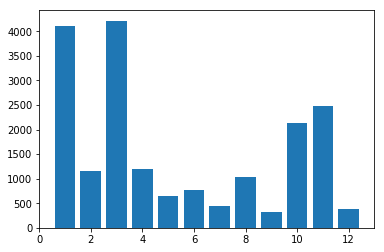

In [42]:
month_counts = (data1['dateSeen_month'].value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'month', 'dateSeen_month': 'count'})
                )
print('These are the following counts by month:')
print(month_counts)
plt.bar(month_counts['month'], month_counts['count'])

The distribution of months during which prices were collected is highly non-uniform, with peaks in January and March, as well as growth in October and November (possibly coinciding with festive/sales events such as Christmas/New Years, Black Friday, etc). That being said, following that train of thought, one might expect more price-tracking in July and December, so it's best not to assume anything other than a non-uniform collection of data points temporally.

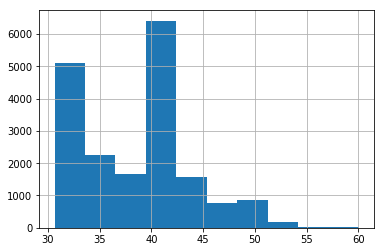

In [43]:
data1['duration_since_dateSeen_month'].hist()

### Currency Exploration

There are 5 different currencies in this dataset.
USD    18348
AUD      335
CAD      103
EUR       66
GBP       22
Name: prices.currency, dtype: int64


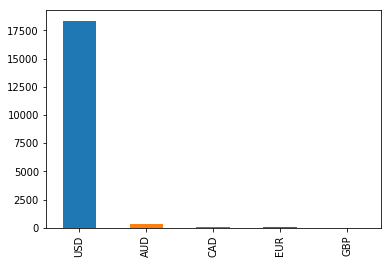

In [44]:
print('There are', data1['prices.currency'].nunique(), 'different currencies in this dataset.')
print(data1['prices.currency'].value_counts())
data1['prices.currency'].value_counts().plot(kind="bar")

The prices in the dataset are clearly dominated by USD pricing. It would probably make sense to convert all prices to USD (as done in 'Feature Engineering' section), since there just wouldn't be a lot of data points for the model to learn to predict in different currencies (+ possible bias in the target variable).

Even if prices are converted, it might still be worth encoding currencies as a categorical variable in case pricing differs per country/currency, even after converting the prices to USD. Time permitted (see 'Further Improvements'), I would try building out *both* models - 1) for predicting prices converted to USD, and 2) for predicting prices based on the currency of interest.

### Price Exploration
This section deep-dives into the disparity between prices.amountMin and prices.amount Max, as well as possible outliers therein.
- As outlined in the introduction, each row represents a product-price tuple: each product can occur in multiple rows if it is listed at multiple different prices on different website listings (sourceURLs).
- Furthermore, the prices on those listings can change over time (temporal element), so:
1. prices.amountMin = MINIMUM price listed for the product on those same sourceURLs
2. prices.amountMax = MAXIMUM price listed for the product on those same sourceURLs

In [45]:
# number of rows where prices.amountMin > prices.amountMax
len(data1[data1['prices.amountMin'] > data1['prices.amountMax']])

0

*Note: all values of prices.amountMin are indeed < prices.amountMax.*

In [46]:
# number of rows where prices.amountMin < prices.amountMax
print('There are',len(data1[data1['prices.amountMin'] < data1['prices.amountMax']]), 'rows with amountMin < amountMax')
print('These rows represent',len(data1[data1['prices.amountMin'] < data1['prices.amountMax']]) / len(data1),'of the data.')

There are 640 rows with amountMin < amountMax
These rows represent 0.03390908127582918 of the data.


Create a new column to investigate the percentage difference between amountMin and amountMax when they differ.

In [47]:
data1['percent_difference'] = (data1['prices.amountMax'] - data1['prices.amountMin']) / data1['prices.amountMax']

In [48]:
amountMin_less_than_amountMax = data1[data1['prices.amountMin'] < data1['prices.amountMax']]
amountMin_less_than_amountMax[['id','isSale','prices.offer','prices.amountMin','prices.amountMax']].head(10)

,id,isSale,prices.offer,prices.amountMin,prices.amountMax
109,AVpfEdjqLJeJML431trL,0,missing,84.85,179.99
189,AVpfG4VH1cnluZ0-eEOn,0,missing,96.44,165.00
190,AVpfG4VH1cnluZ0-eEOn,0,missing,109.00,179.99
191,AVpfG4VH1cnluZ0-eEOn,0,missing,103.01,165.00
192,AVpfG4VH1cnluZ0-eEOn,0,missing,110.00,179.99
236,AVpfCDi91cnluZ0-cabr,0,missing,34.99,42.00
417,AVpe-HGdilAPnD_xSDuY,0,missing,28.95,37.95
465,AVpfDlggLJeJML431aAm,0,missing,114.99,175.00
466,AVpfDlggLJeJML431aAm,0,missing,114.99,174.95
471,AVpfDYmVLJeJML431VWs,0,missing,29.50,45.00


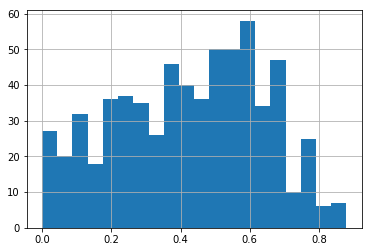

In [49]:
amountMin_less_than_amountMax['percent_difference'].hist(bins=20)

The distribution of the percent difference between amountMin and amountMax (for the products where they're not equal) is actually "somewhat" normal, albeit a bit right skewed. We will proceed nevertheless with using the mean of USD prices as the target variable in our model (since the potentially biased data points represent less than 1% of the data points in the dataset).

In [50]:
# define a column for mean of min and max price converted to USD, and get snapshot of values in dataframe
data1['mean_price_usd'] = data1[['prices.amountMin_converted', 'prices.amountMax_converted']].mean(axis=1)
data1[data1['prices.amountMin'] < data1['prices.amountMax']].head()

,id,asins,brand,categories,colors,descriptions,dimension,ean,features,imageURLs,...,duration_since_dateSeen_month,dateSeen_month,dateSeen_year,URL_clean,URL_domain_clean,conversion,prices.amountMin_converted,prices.amountMax_converted,percent_difference,mean_price_usd
109,AVpfEdjqLJeJML431trL,B00242PMIC,jordan,"shoes,clothing, shoes & jewelry,men,athletic,t...",NaN,NaN,NaN,NaN,NaN,http://ecx.images-amazon.com/images/I/41dfRe0b...,...,45.559186,11,2015,http://www.amazon.com/Jordan-Rising-White-Infr...,amazon,0.743401,84.85,179.99,0.528585,132.420
189,AVpfG4VH1cnluZ0-eEOn,"B005DXAS2E,B005DXB0LM",geox,"loafers & slip-ons,men,shoes,clothing, shoes &...",NaN,NaN,NaN,NaN,NaN,NaN,...,45.756315,10,2015,http://www.amazon.com/Geox-Monet-Plain-Vamp-Le...,amazon,0.743401,96.44,165.00,0.415515,130.720
190,AVpfG4VH1cnluZ0-eEOn,"B005DXAS2E,B005DXB0LM",geox,"loafers & slip-ons,men,shoes,clothing, shoes &...",NaN,NaN,NaN,NaN,NaN,NaN,...,50.027450,6,2015,http://www.amazon.com/Geox-Monet-Plain-Vamp-Le...,amazon,0.743401,109.00,179.99,0.394411,144.495
191,AVpfG4VH1cnluZ0-eEOn,"B005DXAS2E,B005DXB0LM",geox,"loafers & slip-ons,men,shoes,clothing, shoes &...",NaN,NaN,NaN,NaN,NaN,NaN,...,45.822025,10,2015,http://www.amazon.com/Geox-Monet-Plain-Vamp-Le...,amazon,0.743401,103.01,165.00,0.375697,134.005
192,AVpfG4VH1cnluZ0-eEOn,"B005DXAS2E,B005DXB0LM",geox,"loafers & slip-ons,men,shoes,clothing, shoes &...",NaN,NaN,NaN,NaN,NaN,NaN,...,47.629044,9,2015,http://www.amazon.com/Geox-Monet-Plain-Vamp-Le...,amazon,0.743401,110.00,179.99,0.388855,144.995


### Names and Categories

Do some preliminary string cleaning on names and categories (i.e. basic string manipulations - ideally should be lemmatizing and stemming).

In [51]:
data1['name'] = data1['name'].str.lower().str.strip()
data1['categories'] = data1['categories'].str.lower().str.strip()

data1['name'] = data1['name'].str.replace("shoes","shoe")
data1['name'] = data1['name'].str.replace("boots","boot")
data1['name'] = data1['name'].str.replace("sandals","sandal")
data1['name'] = data1['name'].str.replace("sneakers","sneaker")
data1['name'] = data1['name'].str.replace("loafers","loafer")
data1['name'] = data1['name'].str.replace("slippers","slipper")

data1['categories'] = data1['categories'].str.replace("shoes","shoe")
data1['categories'] = data1['categories'].str.replace("boots","boot")
data1['categories'] = data1['categories'].str.replace("sandals","sandal")
data1['categories'] = data1['categories'].str.replace("sneakers","sneaker")
data1['categories'] = data1['categories'].str.replace("loafers","loafer")
data1['categories'] = data1['categories'].str.replace("slippers","slipper")

Use TF-iDF to try extracting a score for relevant category in the product name. <br> *Note: 'Future Improvement', compare the performance when using CountVectorizer for name as well.*

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(data1['name'])

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
nlp_name = pd.DataFrame(values.toarray(), columns = feature_names)
nlp_name = nlp_name[['boot','shoe','footwear','sandal','running',
                     'sneaker','loafer','slipper','moccasin']]

nlp_name.columns = ['nlp_name_' + str(col) for col in nlp_name.columns]

Use Count Vectorization to try extracting a score for relevant category in the product name.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
values = count_vectorizer.fit_transform(data1['categories'])

# Show the Model as a pandas DataFrame
feature_names = count_vectorizer.get_feature_names()
nlp_categories = pd.DataFrame(values.toarray(), columns = feature_names)
nlp_categories = nlp_categories[['boot','shoe','footwear','sandal',
                     'sneaker','loafer','slipper','moccasin','running']]

nlp_categories.columns = ['nlp_cat_' + str(col) for col in nlp_categories.columns]

In [54]:
data1.shape
nlp_name.shape
#nlp_categories.shape

(18874, 9)

In [55]:
data1.reset_index(drop=True,inplace=True)
nlp_name.reset_index(drop=True,inplace=True)
nlp_categories.reset_index(drop=True,inplace=True)

data1 = pd.concat([data1, nlp_name, nlp_categories],axis=1)

In [56]:
data1.shape

(18874, 72)

Define the shoe_name_score to be the NLP-generated column that most closely (max score) matches the name in the data.

In [57]:
data1['shoe_name_score'] = data1[nlp_name.columns].max(axis=1)
data1['shoe_name_score'] = data1['shoe_name_score'].fillna(0)
data1.head(2)

,id,asins,brand,categories,colors,descriptions,dimension,ean,features,imageURLs,...,nlp_cat_boot,nlp_cat_shoe,nlp_cat_footwear,nlp_cat_sandal,nlp_cat_sneaker,nlp_cat_loafer,nlp_cat_slipper,nlp_cat_moccasin,nlp_cat_running,shoe_name_score
0,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoe,men's shoe,all men's shoe",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,0,3,0,0,0,0,0,0,0,0.14022
1,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoe,men's shoe,all men's shoe",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,0,3,0,0,0,0,0,0,0,0.14022


Define the shoe_cat_score to be the NLP-generated column that most closely (max score) matches the category in the data.

In [58]:
data1['shoe_cat_score'] = data1[nlp_categories.columns].max(axis=1)
data1['shoe_cat_score'] = data1['shoe_cat_score'].fillna(0)
data1.head(2)

,id,asins,brand,categories,colors,descriptions,dimension,ean,features,imageURLs,...,nlp_cat_shoe,nlp_cat_footwear,nlp_cat_sandal,nlp_cat_sneaker,nlp_cat_loafer,nlp_cat_slipper,nlp_cat_moccasin,nlp_cat_running,shoe_name_score,shoe_cat_score
0,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoe,men's shoe,all men's shoe",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,3,0,0,0,0,0,0,0,0.14022,3
1,AVpfHrJ6ilAPnD_xVXOI,NaN,josmo,"clothing,shoe,men's shoe,all men's shoe",NaN,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...",NaN,0699302044036,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,...,3,0,0,0,0,0,0,0,0.14022,3


In [59]:
cond_1 = data1['shoe_name_score'] < 0.20
cond_2 = data1['shoe_cat_score'] <= 1
data1[['categories','name','shoe_name_score','shoe_cat_score']][cond_1 & cond_2].head(10)

,categories,name,shoe_name_score,shoe_cat_score
18,"clothing, shoe, accessories,bags, briefcases,m...",men's faux leather business handbag messenger ...,0.0,1
22,"men's halloween costumes,adult halloween costu...",rubies costume adult mens regency plush santa ...,0.0,1
23,"men's halloween costumes,adult halloween costu...",rubies costume adult mens regency plush santa ...,0.0,1
24,"men's halloween costumes,adult halloween costu...",rubies costume adult mens regency plush santa ...,0.0,1
25,"clothing, shoe & accessories,men's clothing,un...",men boxer underwear shorts modal male underpan...,0.0,1
32,"clothing, shoe & accessories,men's clothing,sh...",american fighter by affliction north creek boa...,0.0,1
35,"clothing, shoe, accessories,men's sunglasses",polarized sunglasses maui jim bamboo forest 41...,0.0,1
36,"clothing, shoe & accessories,men's clothing,sh...",venum men's koi compression pants spats mma bl...,0.0,1
37,"all men's clothing,men's clothing,men's outerw...",azzuro cozy fit notched lapel long sleeve blaz...,0.0,1
38,"all men's clothing,men's clothing,men's outerw...",azzuro cozy fit notched lapel long sleeve blaz...,0.0,1


In [60]:
data1['shoe_name_score'].isna().sum()

0

At first glance, some of these NLP scores are problematic because some data points which are clearly shoes (i.e. contain the words that we're defining to be part of the 'shoe' bag of words). I will utilize the scores as features derived from the 'categories' and 'name' columns, and input them into the model as is, but they clearly need more tweaking (see 'Future Improvements').

### Correlation of Features

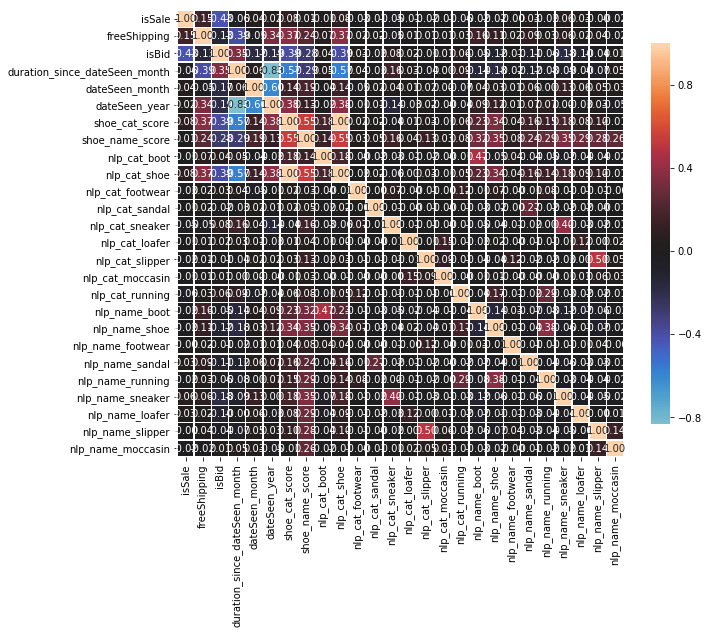

In [61]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_columns = ['brand_clean', 'gender', 'prices.currency', 'isSale', 'freeShipping', 'isBid',
            'duration_since_dateSeen_month','URL_domain_clean','dateSeen_month','dateSeen_year',
            'isNew','withTags','withBox','shoe_cat_score','shoe_name_score']
correlation_columns = correlation_columns + nlp_categories.columns.tolist() + nlp_name.columns.tolist()
    
correlation_heatmap(data1[correlation_columns])

The most problematic columns with respect to correlation are 'dateSeen_year' and 'nlp_cat_shoe'. We will consider removing these features to avoid colinearity in the model (will test to see difference in model's performance with and without them present).

# 5. Benchmarking
I will use both a *measure of central tendency comparison* and *linear regression model* as benchmarks to compare my final model to. A linear regression model is arguably the most basic/displaying of the least competitive accuracy in comparison to other more complex supervised machine learning regression algorithms, so it is a worthy option as a benchmark. It will be contrasted to the worse-case benchmark of using mean and/or median of the target variable as predictions.

#### Preprocessing Data for Linear Model
I will select specific features from the existing + engineered ones in the dataset, and scale them using MinMaxScaler for the linear model. The model will be split into train and test sets respectively. I will use cross validation (GridSearchcv) on the train set to pick the best K fold. Then, I will run predictions on the test set using the model, and compare the predictions to the true values in the test set to get the benchmarking metrics.

#### Model Performance
MSE, RMSE and R2 will be used to evaluate model performance.

## Pre-processing

### Feature Selection
The following features were used as inputs for the linear model:

In [62]:
data1.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'descriptions',
       'dimension', 'ean', 'features', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'name', 'prices.amountMin',
       'prices.amountMax', 'prices.availability', 'prices.color',
       'prices.condition', 'prices.count', 'prices.currency', 'prices.flavor',
       'prices.merchant', 'prices.offer', 'prices.returnPolicy',
       'prices.shipping', 'prices.size', 'prices.sourceURLs', 'reviews',
       'sizes', 'skus', 'sourceURLs', 'upc', 'weight', 'gender', 'isSale',
       'dateSeen', 'brand_clean', 'freeShipping', 'isBid', 'isNew', 'withBox',
       'withTags', 'duration_since_dateSeen_month', 'dateSeen_month',
       'dateSeen_year', 'URL_clean', 'URL_domain_clean', 'conversion',
       'prices.amountMin_converted', 'prices.amountMax_converted',
       'percent_difference', 'mean_price_usd', 'nlp_name_boot',
       'nlp_name_shoe', 'nlp_name_footwear', 'nlp_name_sandal',
       'nl

In [63]:
input_features = ['brand_clean', 'gender', 'prices.currency', 'isSale', 'freeShipping', 'isBid',
            'duration_since_dateSeen_month','URL_domain_clean','dateSeen_month',
            'isNew','withTags','withBox','shoe_cat_score','shoe_name_score']

target_feature = ['mean_price_usd']

X = data1[input_features]
y = data1[target_feature]

X.head(2)

,brand_clean,gender,prices.currency,isSale,freeShipping,isBid,duration_since_dateSeen_month,URL_domain_clean,dateSeen_month,isNew,withTags,withBox,shoe_cat_score,shoe_name_score
0,josmo,Men,USD,1,2,0,33.534298,walmart,11,missing,missing,missing,3,0.14022
1,josmo,Men,USD,0,2,0,33.534298,walmart,11,new,missing,missing,3,0.14022


**Note:** I've explicitly removed 'dateSeen_year' column due to high correlation with columns 'dateSeen_month' and 'duration_since_dateSeen_month'. Further, I've omitted most of the NLP columns safe for the MAX scores due to significant negative impact on the linear model performance; 'nlp_cat_shoe' column in particular due to its perfect correlation with the 'shoe_cat_score' column (to be expected giving the cleaning I did in sections 2. and 3.).

### Preprocessing Features
- one hot encode object features EXCEPT 'brand_clean' (high cardinality categorical feature)
- for 'brand_clean', we will use hash encoding since its a nominal feature with high cardinality

In [64]:
X_dummies = pd.get_dummies(X[X.columns.difference(['brand_clean'])])
X_dummies = X_dummies.drop('URL_domain_clean_ Please use a view that flattens this field to see this data','columns')
X_dummies.head(2)

,dateSeen_month,duration_since_dateSeen_month,freeShipping,isBid,isSale,shoe_cat_score,shoe_name_score,URL_domain_clean_amazon,URL_domain_clean_calvinklein,URL_domain_clean_ebay,...,prices.currency_CAD,prices.currency_EUR,prices.currency_GBP,prices.currency_USD,withBox_missing,withBox_with_box,withBox_without_box,withTags_missing,withTags_with_tags,withTags_without_tags
0,11,33.534298,2,0,1,3,0.14022,0,0,0,...,0,0,0,1,1,0,0,1,0,0
1,11,33.534298,2,0,0,3,0.14022,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [65]:
brand_clean_hash = ce.HashingEncoder(cols = ['brand_clean'])
brand_clean_encoded = brand_clean_hash.fit_transform(X['brand_clean'], y)
brand_clean_encoded.columns = ['brand_clean_' + str(col) for col in brand_clean_encoded.columns]

brand_clean_encoded.head(2)

,brand_clean_col_0,brand_clean_col_1,brand_clean_col_2,brand_clean_col_3,brand_clean_col_4,brand_clean_col_5,brand_clean_col_6,brand_clean_col_7
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0


In [66]:
X_dummies = pd.concat([X_dummies,brand_clean_encoded],axis=1)
X_dummies.head(2)

,dateSeen_month,duration_since_dateSeen_month,freeShipping,isBid,isSale,shoe_cat_score,shoe_name_score,URL_domain_clean_amazon,URL_domain_clean_calvinklein,URL_domain_clean_ebay,...,withTags_with_tags,withTags_without_tags,brand_clean_col_0,brand_clean_col_1,brand_clean_col_2,brand_clean_col_3,brand_clean_col_4,brand_clean_col_5,brand_clean_col_6,brand_clean_col_7
0,11,33.534298,2,0,1,3,0.14022,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,11,33.534298,2,0,0,3,0.14022,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Use MinMaxScaler on the feature set to standardize the input data.

In [67]:
scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X_dummies), columns=X_dummies.columns)
X_scaled.head(2)

,dateSeen_month,duration_since_dateSeen_month,freeShipping,isBid,isSale,shoe_cat_score,shoe_name_score,URL_domain_clean_amazon,URL_domain_clean_calvinklein,URL_domain_clean_ebay,...,withTags_with_tags,withTags_without_tags,brand_clean_col_0,brand_clean_col_1,brand_clean_col_2,brand_clean_col_3,brand_clean_col_4,brand_clean_col_5,brand_clean_col_6,brand_clean_col_7
0,0.909091,0.098324,1.0,0.0,1.0,0.333333,0.192687,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909091,0.098324,1.0,0.0,0.0,0.333333,0.192687,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
y = np.array(y).ravel()
y.shape

(18874,)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
print('Shape of training set is:', X_train.shape)
print('Shape of testing set is:', X_test.shape)

Shape of training set is: (15099, 50)
Shape of testing set is: (3775, 50)


### Train Linear Regression model
- Use gridsearchcv to try out different ranges of k on the training set.
- **NOTE: There was ultimately no real reason to use GridSearchCV since there were no LinearRegression parameters that I felt needed iterating through. I could've instead used a more basic cross-validation method/function to see how splitting the data affected the mean score (GridSearchCV is a bit overkill in this scenario), but if it was another type of problem - say classification - it may still have come in hand.**

In [70]:
linear_model = LinearRegression()
linear_model_params = {}

In [71]:
%%time
linear_model_cv = GridSearchCV(linear_model, param_grid = linear_model_params, cv=4, verbose=3)
linear_model_cv.fit(X_train,y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV]  ................................................................
[CV] .................................... , score=0.205, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.071, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.271, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.077, total=   0.0s
CPU times: user 179 ms, sys: 93.9 ms, total: 273 ms
Wall time: 84.7 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


In [72]:
print('The best R2 / variance score is:', linear_model_cv.best_score_)
print('The best k value is:', linear_model_cv.best_params_)  # overkill for linear regression, few parameters to tweak

The best R2 / variance score is: 0.1560419756604791
The best k value is: {}


In [73]:
# compare model performance to simply using the average of y_train
y_mean = y_train.mean()
y_median = np.median(y_train)
y_mean_predicted = pd.Series(np.tile(y_mean, len(y_test)))

# compute RMSE and R2
mse = metrics.mean_squared_error(y_test, y_mean_predicted)
r2 = metrics.r2_score(y_test, y_mean_predicted)

# printing values
print('Mean squared error: ', mse)
print('Root mean squared error: ', math.sqrt(mse))
print('R2 score: ', r2)

Mean squared error:  104964.15278670496
Root mean squared error:  323.9817167475735
R2 score:  -1.404270285831899e-06


In [74]:
# have a quick peek at y_mean_pred vs y_test side-by-side
pd.DataFrame({'y_test_true':y_test,'y_mean_predicted':y_mean_predicted}).head(10)

,y_test_true,y_mean_predicted
0,160.000000,113.032981
1,59.220000,113.032981
2,110.000000,113.032981
3,110.730000,113.032981
4,49.272573,113.032981
5,74.690000,113.032981
6,17.990000,113.032981
7,17.650000,113.032981
8,74.990000,113.032981
9,82.990000,113.032981


As expected, using metrics of central tendency as y-value baseline predictions (mean and median alike) gives an **R2 score near 0**, i.e. your regression is no better than taking the mean value and you are **not using any information from the other variables**.

Furthermore, the mean squared error score (metric used for scoring our linear regression model) is on the order of 10^5, RMSE on the order of 10^2. Since RMSE is measured in the units of the target variables (USD), it represents a dollar amount by which our baseline predictions are off.

*At least we can rest easy knowing that the basic linear model, however poor its performance, is still performing better than using just a measure of central tendency! Granted, all signs point to the fact that more work likely needs to be done on the feature engineering front.*

### Testing Linear model
- Apply the linear model on full test set and evaluate the model performance using evaluation metrics MSE, RMSE and R2.

In [75]:
%%time
linear_test = LinearRegression()
linear_test.fit(X_train,y_train)
linear_test_predictions = linear_test.predict(X_test)

CPU times: user 37.5 ms, sys: 16 ms, total: 53.5 ms
Wall time: 14.6 ms


In [76]:
print("MSE: ",metrics.mean_squared_error(y_test, linear_test_predictions))
print("RMSE: ",math.sqrt(metrics.mean_squared_error(y_test, linear_test_predictions)))
print("R2 :",metrics.r2_score(y_test, linear_test_predictions))

MSE:  95770.81557033962
RMSE:  309.46860191356996
R2 : 0.08758421312594278


### Results Summary

Unfortunately, it appears the basic linear model **doesn't perform much better than our worse-case measure of central tendency comparison**; notably, R2 is still very low (close to 0, although a bit greater than without the features' information) and the RMSE score is of the same order of magnitued (10^2 in USD).

Though I won't due to time constraints, it's also worth **checking adjusted R2** to make sure the small improvements we're seeing in evaluation metrics (R2 in particular) are simply due to adding new features.

Although I will proceed with trying a more complex supervised regression model, this is **usually a sign we need to re-evaluate our input features + try deriving more valuable features from the data that we have**; or alternatively, **try reframing the task/problem itself** given the data that we have.

# 6.0 Model Implementation (LightGBM)

I will try using a boosting (LightGBM) model for the following reasons:
- Efficient on a large datasets (note on this in 'Future Improvements')
- Handles categorical variables without the need to encode
- Better performance from an evaluation perspective compared to Random Forest and SVM; also less computation intensive than neural networks
- There are many parameters that can be tuned to improve evaluation performance

In [77]:
nlp_name.columns.tolist()

['nlp_name_boot',
 'nlp_name_shoe',
 'nlp_name_footwear',
 'nlp_name_sandal',
 'nlp_name_running',
 'nlp_name_sneaker',
 'nlp_name_loafer',
 'nlp_name_slipper',
 'nlp_name_moccasin']

In [78]:
# Note: dateSeen_year removed due to high correlation with dateSeen_month and duration_since_dateSeen_month
# led to negligeable impact on the model

numeric_features = ['isSale', 'freeShipping', 'isBid',
                    'duration_since_dateSeen_month','dateSeen_month',
                    'shoe_cat_score','shoe_name_score']

nlp_cat_subset = ['nlp_cat_boot',
 'nlp_cat_shoe',
 'nlp_cat_sneaker']

nlp_name_subset = ['nlp_name_boot',
 'nlp_name_shoe',
 'nlp_name_sandal',
 'nlp_name_running',
 'nlp_name_sneaker',
 'nlp_name_loafer',
 'nlp_name_slipper',
 'nlp_name_moccasin']

numeric_features = numeric_features + nlp_cat_subset + nlp_name_subset

categorical_features = ['brand_clean', 'gender', 'isNew', 'withTags', 'withBox', 
                        'prices.currency', 'URL_domain_clean']

target_feature = ['mean_price_usd']

y = data1[target_feature]

In [79]:
numerical_data = data1[numeric_features]

scaler = MinMaxScaler()
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns = numerical_data.columns)

In [80]:
categorical_data = data1[categorical_features]
for col in categorical_data.columns: 
     categorical_data[col] = categorical_data[col].astype('category')

print('Converting object variables to type category for lightgbm: ')
categorical_data.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Converting object variables to type category for lightgbm: 


brand_clean         category
gender              category
isNew               category
withTags            category
withBox             category
prices.currency     category
URL_domain_clean    category
dtype: object

In [81]:
X_lgbm = pd.concat([numerical_data_scaled.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
print('Features selected for lightgbm model based on feature importance and trial and error:')
X_lgbm.columns

Features selected for lightgbm model based on feature importance and trial and error:


Index(['isSale', 'freeShipping', 'isBid', 'duration_since_dateSeen_month',
       'dateSeen_month', 'shoe_cat_score', 'shoe_name_score', 'nlp_cat_boot',
       'nlp_cat_shoe', 'nlp_cat_sneaker', 'nlp_name_boot', 'nlp_name_shoe',
       'nlp_name_sandal', 'nlp_name_running', 'nlp_name_sneaker',
       'nlp_name_loafer', 'nlp_name_slipper', 'nlp_name_moccasin',
       'brand_clean', 'gender', 'isNew', 'withTags', 'withBox',
       'prices.currency', 'URL_domain_clean'],
      dtype='object')

In [82]:
X_data, X_test, y_data, y_test = train_test_split(X_lgbm, y, test_size=0.2, random_state=42) #Updated
print('Shape of train set is:', X_data.shape)  
print('Shape of testing set is:', X_test.shape)

Shape of train set is: (15099, 25)
Shape of testing set is: (3775, 25)


In [83]:
def lgbm_model(X_data, y_data, params, n_folds):
    n_folds = KFold(n_splits=n_folds)
    X_data = X_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    
    
    train_mse = []
    train_rmse = []
    train_r2 = []
    validation_mse = []
    validation_rmse = []
    validation_r2 = []
    
    for train_index, validate_index in n_folds.split(X_data):
        
        X_train, X_validate = X_data.iloc[train_index], X_data.iloc[validate_index]
        y_train, y_validate = y_data.iloc[train_index], y_data.iloc[validate_index]
        
        
        lgb_model = lgb.LGBMRegressor(**params, n_jobs=5)
        
        # train the model
        lgb_model.fit(X_train, y_train, early_stopping_rounds=50, 
                      eval_set=(X_validate, y_validate), eval_metric='l2')

        # get train rmse and r2
        y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration_)

        # get validation rmse and r2
        y_pred = lgb_model.predict(X_validate, num_iteration=lgb_model.best_iteration_)

        train_mse.append(metrics.mean_squared_error(y_train, y_train_pred))
        train_rmse.append(math.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
        train_r2.append(metrics.r2_score(y_train, y_train_pred))

        validation_mse.append(metrics.mean_squared_error(y_validate, y_pred))
        validation_rmse.append(math.sqrt(metrics.mean_squared_error(y_validate, y_pred)))
        validation_r2.append(metrics.r2_score(y_validate, y_pred))    
    
    
    return [pd.DataFrame(train_mse).mean().values[0], 
            pd.DataFrame(train_rmse).mean().values[0], 
            pd.DataFrame(train_r2).mean().values[0],
            pd.DataFrame(validation_mse).mean().values[0], 
            pd.DataFrame(validation_rmse).mean().values[0], 
            pd.DataFrame(validation_r2).mean().values[0]], lgb_model

In [84]:
params = {'learning_rate':0.08,
         'boosting_type': 'gbdt',
         'num_leaves':20,
         'objective':'regression',
         'metric': 'l1',
         'max_depth': 4,
         'max_bin': 50,
         'feature_fraction': 0.5,
         'reg_alpha': 0.5,
         'reg_lambda': 0.5,
         'min_gain_to_split': 0.2,
         'n_estimators': 100,
         'num_iterations': 90,
         'min_split_gain': 0.08,
         'min_child_samples': 5}

In [85]:
model_eval, result_model = lgbm_model(X_data, y_data,params,  5)

[1]	valid_0's l2: 39403.5	valid_0's l1: 86.3906
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 37833.7	valid_0's l1: 83.8002
[3]	valid_0's l2: 36299.4	valid_0's l1: 81.2633
[4]	valid_0's l2: 35055.7	valid_0's l1: 79.6185
[5]	valid_0's l2: 34138	valid_0's l1: 78.46
[6]	valid_0's l2: 33267.5	valid_0's l1: 77.2665
[7]	valid_0's l2: 32392	valid_0's l1: 75.1701
[8]	valid_0's l2: 31749.7	valid_0's l1: 74.2724
[9]	valid_0's l2: 31261.3	valid_0's l1: 73.2828
[10]	valid_0's l2: 30704.8	valid_0's l1: 72.3628
[11]	valid_0's l2: 30101.2	valid_0's l1: 70.6852
[12]	valid_0's l2: 29558	valid_0's l1: 69.1741
[13]	valid_0's l2: 29171	valid_0's l1: 68.198
[14]	valid_0's l2: 28818.5	valid_0's l1: 67.2476
[15]	valid_0's l2: 28642.3	valid_0's l1: 66.9385
[16]	valid_0's l2: 28447.5	valid_0's l1: 66.3351
[17]	valid_0's l2: 28302.2	valid_0's l1: 65.976
[18]	valid_0's l2: 28103	valid_0's l1: 65.3637
[19]	valid_0's l2: 27864.4	valid_0's l1: 64.6103
[20]	valid_0's l2: 27628.3	val

/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 117195	valid_0's l1: 88.9688
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 115830	valid_0's l1: 86.5413
[3]	valid_0's l2: 114322	valid_0's l1: 83.9777
[4]	valid_0's l2: 113159	valid_0's l1: 82.3151
[5]	valid_0's l2: 112191	valid_0's l1: 81.122
[6]	valid_0's l2: 111418	valid_0's l1: 80.0316
[7]	valid_0's l2: 110619	valid_0's l1: 77.9809
[8]	valid_0's l2: 109908	valid_0's l1: 76.9983
[9]	valid_0's l2: 109358	valid_0's l1: 75.9764
[10]	valid_0's l2: 108802	valid_0's l1: 74.9903
[11]	valid_0's l2: 108272	valid_0's l1: 73.3814
[12]	valid_0's l2: 107779	valid_0's l1: 72.0775
[13]	valid_0's l2: 107362	valid_0's l1: 71.2055
[14]	valid_0's l2: 107037	valid_0's l1: 70.1954
[15]	valid_0's l2: 106662	valid_0's l1: 69.7819
[16]	valid_0's l2: 106423	valid_0's l1: 69.0633
[17]	valid_0's l2: 106119	valid_0's l1: 68.694
[18]	valid_0's l2: 105879	valid_0's l1: 67.9948
[19]	valid_0's l2: 105691	valid_0's l1: 67.2697
[20]	valid_0's l2: 105477	valid_0's l

/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's l2: 19480	valid_0's l1: 57.7295
[32]	valid_0's l2: 19407.8	valid_0's l1: 57.4764
[33]	valid_0's l2: 19377.9	valid_0's l1: 57.542
[34]	valid_0's l2: 19338.9	valid_0's l1: 57.3846
[35]	valid_0's l2: 19282	valid_0's l1: 57.1718
[36]	valid_0's l2: 19211.6	valid_0's l1: 56.8603
[37]	valid_0's l2: 19163.8	valid_0's l1: 56.6155
[38]	valid_0's l2: 19116.6	valid_0's l1: 56.3982
[39]	valid_0's l2: 19084.1	valid_0's l1: 56.2535
[40]	valid_0's l2: 19096.8	valid_0's l1: 56.2189
[41]	valid_0's l2: 19079.6	valid_0's l1: 56.1215
[42]	valid_0's l2: 19038.5	valid_0's l1: 55.9586
[43]	valid_0's l2: 19006.2	valid_0's l1: 55.8479
[44]	valid_0's l2: 18987.8	valid_0's l1: 55.7297
[45]	valid_0's l2: 18966.5	valid_0's l1: 55.6579
[46]	valid_0's l2: 18955.2	valid_0's l1: 55.5718
[47]	valid_0's l2: 18934	valid_0's l1: 55.476
[48]	valid_0's l2: 18921.7	valid_0's l1: 55.4187
[49]	valid_0's l2: 18912.5	valid_0's l1: 55.3407
[50]	valid_0's l2: 18883.7	valid_0's l1: 55.2195
[51]	valid_0's l2: 18903	val

[88]	valid_0's l2: 105457	valid_0's l1: 57.426
[89]	valid_0's l2: 105412	valid_0's l1: 57.4114
[90]	valid_0's l2: 105405	valid_0's l1: 57.3677
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 105405	valid_0's l1: 57.3677


/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [86]:
print("Train MSE:",model_eval[0])
print("Train RMSE:",model_eval[1])
print("Train R2:",model_eval[2])
print()
print("Validation MSE:",model_eval[3])
print("Validation RMSE:",model_eval[4])
print("Validation R2:",model_eval[5])

Train MSE: 54152.192870355546
Train RMSE: 231.83767626733402
Train R2: 0.24969104636289474

Validation MSE: 56057.96978601177
Validation RMSE: 221.9822457375664
Validation R2: 0.28469013569772733


Feature importance barplot:


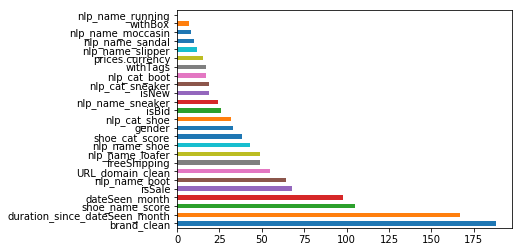

In [87]:
print('Feature importance barplot:')
(pd.Series(result_model.feature_importances_, index=X_lgbm.columns)
   .nlargest(40)
   .plot(kind='barh'))

In [88]:
y_pred = result_model.predict(X_test, num_iteration=result_model.best_iteration_)
print("Test MSE:",metrics.mean_squared_error(y_test, y_pred))
print("Test RMSE:",math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test R2:",metrics.r2_score(y_test, y_pred))

Test MSE: 88788.67273620391
Test RMSE: 297.9742820046789
Test R2: 0.15410361478433254


### Model Implementation Summary

In summary, the performance of the LightGBM model as implemented **did not yield the low error (MSE, RMSE)/high explanation of variance (R2 score) result** that an applicant like myself might have hoped for. It did demonstrate a *small improvement in performance over the baseline model (linear regression model)* and the *worse-case scenario analysis (measure of central tendency comparison)* in the test fitting.

Train, validation and test set MSE, RMSE and R2 are (54152, 231 USD, 25%), (56058, 222 USD, 29%) and (88788, 298, 15%)

Listed below are some of the pros and cons of the LightGBM mode as currently implemented:

##### Pros

- The test set predictions vs true test values' R2 score explained a meager **7%** more of the variance in the data than the test set using the linear model (and that's before considering R2). That's also **15%** more than the worse case scenario (R2 of ~0).<br><br>

- Similarly, the RMSE of the LightGBM model's performance was reduced by **11.50 USD** from the RMSE of the linear model's performance (noting that RMSE is in USD, the units of the target variable). Given that the average value of the target variable (y_test) is **~113 USD**, that's a favorable dollar value decrease in error with respect to the average price of test set products - however, it is nowhere near the dollar value of RMSE error.<br><br>

- (Similar results apply for MSE, however the units are in USD squared - arguably less intuitive if there's a need for explainability to a stakeholder or client.)<br><br>

- As discussed in 'Cons', I was not able to programatically optimize the hyperparameter tuning of the model (say, using Bayesian Optimization). This can also be a pro as it means the performance of the model can still improve with additional hyperparameter tweaking.<br><br>

- Although LightGBM typically performs better on larger datasets than the one at hand (say, 100K+ rows of data points), the model still demonstrated a minute increase with respect to the baseline model (both the linear and worse case).<br><br>

##### Cons

- The model is clearly overfitting the training data despite my attempts to tweak the regularization parameters in LightGBM (L1, L2 costs). This is arguably the biggest problem with the model at the moment - due in part to using such a complex supervised learning model that can be prone to overfitting. Perhaps comparing the current evaluation metrics to those of other techniques (ensemble methods, for example) would be worth a shot. On the training and validation sets, the model can perform as well as explaining 50% of the variance in the data (be careful, needs to be sanity-checked with adjusted_R2) and brings the RMSE down to the order of 10^1 USD. For those values, the model did not generalize to similar evaluation metrics on the test set, however.<br><br>

- Additional hyperparameter tuning is needed to fully leverage the power of the current modelling technique + improve its performance (discussed in 'Future Improvements' as well).<br><br>

- The performance is still not ideal given that the order of magnitude of test set RMSE is on par with that of the average target variable value. Although the **R2 score already doesn't look immediately appealing, the RMSE score confirms that the dollar-value error is too large for this model to confidently predict men's shoe prices to a reasonable confidence level.**<br><br>

- Furthermore, given more time, I would also evaluate **adjusted_R2**; which is a **function of the number of independent variables in the model**. It's possible that the percentage of variance in the data explained by the model will decrease once the number of independent features are accounted for. That being said, the current model does not suffer from worryingly high dimensionality, so it would likely not decrease dramatically in explained variance.<br><br>

### Conclusion

**Ultimately, I would not advise using this model for men's shoe prices' predictions in production in its current implementation.**

# Future Improvements

1. Additional **data cleaning** for missing and erroneous values
2. Free shipping and free returns currently lumped together
3. **Predicting any currency price** as opposed to **predicting USD-converted mean price**
4. Improve (currently rudimentary) **NLP modelling**
5. **Increase dataset size** + supplement with 3rd party data; additional (clean) data points should theoretically improve LightGBM’s evaluation metric performance
6. More explicit **hyperparameter tuning (Bayesian Optimization)**
7. Better leverage of the **prices.offer column** for discount data.

**1.** I know for a fact that there are still non-men's shoe products contained within the dataset that may or may not be skewing the distribution of prices + introducing biases. Additional cleaning is required, in particular in the name and categories columns - to be explicit, removing rows/data points (products in particular) whose category is not part of men's shoes. (Recall the apriori assumption that we would include all men's footwear in this analysis; mocassins, slippers, etc). This might in turn improve the NLP performance of the nlp_cat_score and nlp_name_score columns.<br><br>

**2.** I would hypothesize that this improvement would have little impact on the model's performance overall, but free shipping and free returns are currently being encoded together in the same categorical column. The suggested improvement would be to make separate encodings for each field: increases dimensionality and sparseness (possibly for little payoff), but worth revisiting. Low priority improvement.<br><br>

**3.** Currently, the model is training and testing on prices converted entirely to USD. It could be worth seeing how the model performs keeping the mean prices in their original listing currencies (granted, it would introduce additional complications - like assessing RMSE of a target variable that is theoretically in different units). Would likely involve having to reformulate the problem itself.<br><br>

**4.** The NLP modelling of the name and category columns completed so far has been very basic given the time constraint of the project, but already some of the feature-engineered columns demonstrate high importance in the model's performance. With a more thorough NLP assessment of those two columns (and other high cardinality ordinal columns like brand, among others), I believe NLP-based "binning" of the products will greatly improve the model's ability to discern product segmentation with respect to price.<br><br>

**5.** LightGBM is a complex supervised learning model that usually works best when supplemented with large amounts of data (due to the bias-variance tradeoff, there is an inherent danger of overfitting the training set). Acquiring more data points for the model **may** help with performance - emphasis is on help since, as I previously mentioned, the model would benefit most from either re-engineering the input features, or reframing the target of the problem.<br> Furthermore, we can try supplementing the existing data with external 3rd party data. For example, we can join Amazon Product Advertising API data on the ASIN column (granted, there is a lot of missing data in the column currently), which could add additional features like SalesRank for measuring the relative popularity of a product on Amazon's platform to other products in its 'category'. My recommendation would still be to improve the model performance first (by improving the feature engineering process) before trying to throw more data at it.<br><br>

**6.** More explicit hyperparameter tuning (which would benefit in optimization performance from the increase in dataset row-size from 5). A common method utilized in tandem with LightGBM for parameter optimization is Bayesian Optimization, a technique I did not have time to implement given the time constraint. It may be worth trying in the future to see if it improves performance at all and solves the issue of overfitting the training set.<br><br>

**7.** I hypothesize that better leveraging the *'prices.offer'* column of the dataset could lead to a significant improvement in performance via additional feature engineering that I was unable to tap into given the assignment time constraint. As far as columns of Strings go in the dataset, it is arguably one of the best formatted and easiest to extract valuable information from using simple string manipulation. I should have prioritized feature engineering from this column over some of the other categorical encoding variables that I spent time on (like withTags which ended up having a low feature importance, etc). Given more time, I would attempt to extract columns for a USD dollar amount of discount and percentage discount respectively using string manipulations (maybe NLP if necessary, but don't think it would be at first sight).